# Прогнозирование оттока клиентов телеком-оператора «ТелеДом»

**Цель проекта**

Разработать модель машинного обучения для прогноза оттока клиентов оператора «ТелеДом».<br>
Задача модели – по историческим данным о договорах, персональных характеристиках клиентов и используемых услугах предсказать, разорвёт ли клиент договор.

**Бизнес-цель**

Снижение оттока клиентов за счёт раннего выявления абонентов, склонных к уходу, и применения к ним удерживающих предложений (скидки, промокоды, специальные условия).

**Описание проекта**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных** 

Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Файл `contract_new.csv`
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

Файл `personal_new.csv`
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

Файл `internet_new.csv`
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

Файл `phone_new.csv`
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

**План работы**
1. Загрузка и первичный осмотр данных.
2. Исследовательский анализ и предобработка датасетов.
3. Объединение данных в единый датафрейм.
4. Анализ объединённого датафрейма и генерация признаков.
5. Подготовка данных к моделированию.
6. Обучение и подбор гиперпараметров моделей.
7. Оценка качества и выбор лучшей модели.
8. Итоговые выводы и рекомендации для бизнеса.

## Загрузка и просмотр данных

In [1]:
!pip install phik

In [2]:
# Подключение всех необходимых библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from datetime import datetime

import phik

# Настройка pandas для отображения полного текста
pd.set_option('display.max_colwidth', None)

# Задаем стиль графиков
sns.set(style="whitegrid", palette="pastel")

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, make_scorer, roc_auc_score, accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

RANDOM_STATE = 250825
CONTROL_DATE = pd.Timestamp("2020-02-01")  # дата актуальности среза по условию

In [3]:
# Загружает CSV-файл и выводит случайные строки и общую информацию
def load_and_inspect_csv(filepath, delimiter=',', sample_size=5):
    if os.path.exists(filepath):
        df = pd.read_csv(filepath, delimiter=delimiter)
        print(f"Файл успешно загружен: {filepath}")
        display(df.sample(sample_size, random_state=42))
        df.info()
        return df
    else:
        print(f"Файл не найден: {filepath}")
        return None

In [4]:
# Изучим данные
contract_raw = load_and_inspect_csv('/datasets/contract_new.csv')

Файл успешно загружен: /datasets/contract_new.csv


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
185,1024-GUALD,2019-10-01,No,Month-to-month,Yes,Electronic check,24.80,99.2
2715,0484-JPBRU,2016-09-01,No,Month-to-month,Yes,Bank transfer (automatic),25.25,1107.72
3825,3620-EHIMZ,2015-10-01,No,Two year,No,Mailed check,19.35,1066.57
1807,6910-HADCM,2019-09-01,No,Month-to-month,No,Electronic check,76.35,400.84
132,8587-XYZSF,2014-07-01,No,Two year,No,Bank transfer (automatic),50.55,3691.67


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


`contract_new.csv` – содержит сведения о договорах (7043 записи, 8 признаков). Здесь зафиксированы даты начала и окончания действия договора, тип оплаты, наличие электронного счёта, способ платежа, ежемесячные и суммарные расходы клиента. Поле TotalCharges хранится в текстовом формате и потребует преобразования.

In [5]:
# Изучим данные
personal_raw = load_and_inspect_csv('/datasets/personal_new.csv')

Файл успешно загружен: /datasets/personal_new.csv


,customerID,gender,SeniorCitizen,Partner,Dependents
185,1024-GUALD,Female,0,Yes,No
2715,0484-JPBRU,Male,0,No,No
3825,3620-EHIMZ,Female,0,Yes,Yes
1807,6910-HADCM,Female,0,No,No
132,8587-XYZSF,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


`personal_new.csv` – содержит персональные данные абонентов (7043 записи, 5 признаков). В таблице указаны пол клиента, принадлежность к категории «пенсионер», а также наличие супруга и детей.

In [6]:
# Изучим данные
internet_raw = load_and_inspect_csv('/datasets/internet_new.csv')

Файл успешно загружен: /datasets/internet_new.csv


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1615,1170-SASML,Fiber optic,No,Yes,Yes,No,No,No
1874,9314-QDMDW,DSL,No,Yes,No,No,Yes,No
3167,2434-EEVDB,Fiber optic,Yes,No,Yes,No,Yes,No
5287,7672-VFMXZ,DSL,Yes,No,No,Yes,No,No
4770,7445-WMRBW,DSL,No,Yes,Yes,Yes,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


`internet_new.csv` – отражает информацию об интернет-услугах (5517 записей, 8 признаков). Доступны сведения о типе подключения и дополнительных сервисах (блокировка сайтов, антивирус, облачное хранилище, техподдержка, стриминговые сервисы).

In [7]:
# Изучим данные
phone_raw = load_and_inspect_csv('/datasets/phone_new.csv')

Файл успешно загружен: /datasets/phone_new.csv


,customerID,MultipleLines
4743,5887-IKKYO,Yes
4825,7718-UPSKJ,No
472,3571-DPYUH,Yes
2722,3769-MHZNV,No
932,6732-FZUGP,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


`phone_new.csv` – содержит данные об услугах телефонии (6361 запись, 2 признака). Признак показывает, подключен ли телефон к нескольким линиям.

Таким образом, мы загрузили и изучили наши данные. Общим ключом во всех таблицах является `customerID`.<br>
Наборы данных различаются по размерности: не все клиенты пользуются интернетом или телефоном, поэтому в соответствующих таблицах меньше строк, чем в данных о договорах.

## Исследовательский анализ и предобработка данных

In [8]:
def inspect_df(df: pd.DataFrame, id_cols=None, top_n: int = 3, name: str = None):
    """
    Лёгкий первичный осмотр датафрейма:
    - shape, dtypes, пропуски, дубликаты
    - describe() для числовых
    - для текстовых: n_unique, мода, её частота, топ-N значений
    Колонки-ID исключаются из статистики.
    """
    name = name or "DataFrame"
    id_cols = set((id_cols or [])) | {c for c in df.columns if "id" in c.lower()}

    print(f"=== {name}: shape={df.shape[0]}x{df.shape[1]} ===")
    print("Дубликаты:", int(df.duplicated().sum()))
    print("\nDtypes:")
    print(df.dtypes.astype(str))

    miss = pd.DataFrame({
        "missing": df.isna().sum(),
        "missing_%": (df.isna().mean()*100).round(2)
    }).sort_values("missing", ascending=False)
    print("\nПропуски (top 10):")
    print(miss.head(10))

    cols_for_stats = [c for c in df.columns if c not in id_cols]
    num_cols = [c for c in cols_for_stats if pd.api.types.is_numeric_dtype(df[c])]
    obj_cols = [c for c in cols_for_stats if pd.api.types.is_object_dtype(df[c]) or pd.api.types.is_categorical_dtype(df[c])]

    if num_cols:
        print("\nЧисловая статистика (describe):")
        display(df[num_cols].describe().T)

    if obj_cols:
        print("\nКатегориальная статистика:")
        rows = []
        for c in obj_cols:
            vc = df[c].value_counts(dropna=True)
            top_vals = vc.head(top_n)
            rows.append({
                "feature": c,
                "n_unique": int(df[c].nunique(dropna=True)),
                "mode": top_vals.index[0] if len(top_vals) > 0 else np.nan,
                "mode_freq": int(top_vals.iloc[0]) if len(top_vals) > 0 else 0,
                **{f"top{i+1}_value": (top_vals.index[i] if len(top_vals)>i else np.nan) for i in range(top_n)},
                **{f"top{i+1}_freq": (int(top_vals.iloc[i]) if len(top_vals)>i else np.nan) for i in range(top_n)}
            })
        display(pd.DataFrame(rows).set_index("feature"))

### contract_new.csv

In [9]:
inspect_df(contract_raw, id_cols=["customerID"], name="contract_raw")

=== contract_raw: shape=7043x8 ===
Дубликаты: 0

Dtypes:
customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

Пропуски (top 10):
                  missing  missing_%
customerID              0        0.0
BeginDate               0        0.0
EndDate                 0        0.0
Type                    0        0.0
PaperlessBilling        0        0.0
PaymentMethod           0        0.0
MonthlyCharges          0        0.0
TotalCharges            0        0.0

Числовая статистика (describe):


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75



Категориальная статистика:


,n_unique,mode,mode_freq,top1_value,top2_value,top3_value,top1_freq,top2_freq,top3_freq
feature,,,,,,,,,
BeginDate,77,2014-02-01,366,2014-02-01,2019-11-01,2019-10-01,366,237,237.0
EndDate,67,No,5942,No,2020-01-01,2019-12-01,5942,39,38.0
Type,3,Month-to-month,3875,Month-to-month,Two year,One year,3875,1695,1473.0
PaperlessBilling,2,Yes,4171,Yes,No,NaN,4171,2872,NaN
PaymentMethod,4,Electronic check,2365,Electronic check,Mailed check,Bank transfer (automatic),2365,1612,1544.0
TotalCharges,6658,,11,,20.45,101.0,11,6,5.0


- преобразуем `BeginDate` и `EndDate` в формат дат;
- сформируем целевой признак `Churn` (1 – расторгнут, 0 – активен);
- рассчитаем стаж обслуживания `TenureMonths` относительно 2020-02-01;
- `TotalCharges` приведём к типу `float`.

In [10]:
contract = contract_raw.copy()

# Даты
contract["BeginDate"] = pd.to_datetime(contract["BeginDate"], errors="coerce")

# EndDate: "No" → активен (NaT), иначе преобразуем к дате
end_is_no = contract["EndDate"].astype(str).str.lower().eq("no")
contract.loc[end_is_no, "EndDate"] = pd.NaT
contract.loc[~end_is_no, "EndDate"] = pd.to_datetime(contract.loc[~end_is_no, "EndDate"], errors="coerce")

# Целевая переменная Churn
contract["Churn"] = (~end_is_no).astype(int)

# Стаж обслуживания (в месяцах, грубо через среднюю длину месяца)
end_for_tenure = contract["EndDate"].fillna(CONTROL_DATE)
tenure_days = (end_for_tenure - contract["BeginDate"]).dt.days
contract["TenureMonths"] = (tenure_days / 30.4375).clip(lower=0).round().astype("Int64")

# TotalCharges -> float (чистка и конвертация)
contract["TotalCharges"] = pd.to_numeric(contract["TotalCharges"], errors="coerce")
mask_nan = contract["TotalCharges"].isna()

contract.loc[mask_nan, "TotalCharges"] = (
    contract.loc[mask_nan, "MonthlyCharges"] * contract.loc[mask_nan, "TenureMonths"].fillna(0)
)

# Для клиентов с TenureMonths == 0 ставим TotalCharges = 0
contract.loc[contract["TenureMonths"] == 0, "TotalCharges"] = 0

# Контрольный осмотр
inspect_df(contract, id_cols=["customerID"], name="contract_clean")
contract.head()

=== contract_clean: shape=7043x10 ===
Дубликаты: 0

Dtypes:
customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
Churn                        int64
TenureMonths                 Int64
dtype: object

Пропуски (top 10):
                  missing  missing_%
EndDate              5942      84.37
customerID              0       0.00
BeginDate               0       0.00
Type                    0       0.00
PaperlessBilling        0       0.00
PaymentMethod           0       0.00
MonthlyCharges          0       0.00
TotalCharges            0       0.00
Churn                   0       0.00
TenureMonths            0       0.00

Числовая статистика (describe):


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2115.312885,2112.742814,0.00,436.75,1343.35,3236.69,9221.38
Churn,7043.0,0.156325,0.363189,0.00,0.00,0.00,0.00,1.00
TenureMonths,7043.0,29.495385,22.446726,0.00,9.00,25.00,48.00,76.00



Категориальная статистика:


,n_unique,mode,mode_freq,top1_value,top2_value,top3_value,top1_freq,top2_freq,top3_freq
feature,,,,,,,,,
EndDate,66,2020-01-01 00:00:00,39,2020-01-01 00:00:00,2019-12-01 00:00:00,2018-11-01 00:00:00,39,38,35.0
Type,3,Month-to-month,3875,Month-to-month,Two year,One year,3875,1695,1473.0
PaperlessBilling,2,Yes,4171,Yes,No,NaN,4171,2872,NaN
PaymentMethod,4,Electronic check,2365,Electronic check,Mailed check,Bank transfer (automatic),2365,1612,1544.0


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureMonths
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0,34
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,0,4
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,0,45
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,0,5


Таким образом, таблица содержит данные о договорах и платежах клиентов. Основные признаки, которые можно использовать для построения модели прогноза оттока:
- `Type` – тип договора (ежемесячный, годовой, двухгодовой);
- `PaperlessBilling` – наличие электронного счёта;
- `PaymentMethod` – способ оплаты;
- `MonthlyCharges` – ежемесячные расходы;
- `TotalCharges` – суммарные расходы за весь период;
- `TenureMonths` – длительность обслуживания в месяцах (рассчитанный признак).

Целевая переменная – `Churn` (расторгнут договор или нет).

### personal_new.csv

In [11]:
inspect_df(personal_raw, id_cols=["customerID"], name="personal_raw")

=== personal_raw: shape=7043x5 ===
Дубликаты: 0

Dtypes:
customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

Пропуски (top 10):
               missing  missing_%
customerID           0        0.0
gender               0        0.0
SeniorCitizen        0        0.0
Partner              0        0.0
Dependents           0        0.0

Числовая статистика (describe):


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0



Категориальная статистика:


,n_unique,mode,mode_freq,top1_value,top2_value,top3_value,top1_freq,top2_freq,top3_freq
feature,,,,,,,,,
gender,2,Male,3555,Male,Female,NaN,3555,3488,NaN
Partner,2,No,3641,No,Yes,NaN,3641,3402,NaN
Dependents,2,No,4933,No,Yes,NaN,4933,2110,NaN


In [12]:
personal = personal_raw.copy()
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Итак, таблица содержит персональные данные клиентов (7043 записи). В ней отражены пол (`gender`), принадлежность к категории «пенсионер» (`SeniorCitizen`), наличие супруга или супруги (`Partner`), а также наличие детей (`Dependents`). Пропусков и дубликатов нет, значения корректные. Признаки будут использоваться в качестве входных переменных в модели и преобразованы при подготовке данных.

### internet_new.csv

In [13]:
inspect_df(internet_raw, id_cols=["customerID"], name="internet_raw")

=== internet_raw: shape=5517x8 ===
Дубликаты: 0

Dtypes:
customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

Пропуски (top 10):
                  missing  missing_%
customerID              0        0.0
InternetService         0        0.0
OnlineSecurity          0        0.0
OnlineBackup            0        0.0
DeviceProtection        0        0.0
TechSupport             0        0.0
StreamingTV             0        0.0
StreamingMovies         0        0.0

Категориальная статистика:


,n_unique,mode,mode_freq,top1_value,top2_value,top3_value,top1_freq,top2_freq,top3_freq
feature,,,,,,,,,
InternetService,2,Fiber optic,3096,Fiber optic,DSL,NaN,3096,2421,NaN
OnlineSecurity,2,No,3498,No,Yes,NaN,3498,2019,NaN
OnlineBackup,2,No,3088,No,Yes,NaN,3088,2429,NaN
DeviceProtection,2,No,3095,No,Yes,NaN,3095,2422,NaN
TechSupport,2,No,3473,No,Yes,NaN,3473,2044,NaN
StreamingTV,2,No,2810,No,Yes,NaN,2810,2707,NaN
StreamingMovies,2,No,2785,No,Yes,NaN,2785,2732,NaN


In [14]:
internet = internet_raw.copy()
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Данная таблица содержит информацию об интернет-услугах клиентов (5517 записей). В ней указаны тип подключения (`DSL` или `Fiber optic`) и наличие дополнительных сервисов: блокировка опасных сайтов (`OnlineSecurity`), резервное копирование данных (`OnlineBackup`), антивирус (`DeviceProtection`), выделенная линия поддержки (`TechSupport`), стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`). Пропусков и дубликатов нет, все признаки категориальные. Количество строк меньше, чем в таблицах с договорами и персональными данными, так как не все клиенты пользуются интернет-услугами. Все эти признаки будут использованы при обучении модели после кодирования категориальных значений.

### phone_new.csv

In [15]:
inspect_df(phone_raw, id_cols=["customerID"], name="phone_raw")

=== phone_raw: shape=6361x2 ===
Дубликаты: 0

Dtypes:
customerID       object
MultipleLines    object
dtype: object

Пропуски (top 10):
               missing  missing_%
customerID           0        0.0
MultipleLines        0        0.0

Категориальная статистика:


,n_unique,mode,mode_freq,top1_value,top2_value,top3_value,top1_freq,top2_freq,top3_freq
feature,,,,,,,,,
MultipleLines,2,No,3390,No,Yes,NaN,3390,2971,NaN


In [16]:
phone = phone_raw.copy()
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Таблица содержит данные об услугах стационарной телефонии (6361 запись). Признак `MultipleLines` отражает наличие подключения телефона к нескольким линиям одновременно (`Yes`/`No`). Пропусков и дубликатов нет, значения корректные. Количество записей меньше, чем в основной таблице, поскольку часть клиентов не пользуется услугами стационарного телефона. Признак может быть использован в качестве дополнительного фактора при построении модели после кодирования категориальных значений.

## Объединение данных

Для дальнейшего анализа и построения модели необходимо объединить все таблицы в один датафрейм.

- Ключ для объединения – `customerID`.
- В качестве основы возьмём таблицу с договорами (`contract`), так как она содержит целевую переменную `Churn`.
- К ней присоединим персональные данные (`personal`), данные об интернет-услугах (`internet`) и телефонии (`phone`).
- Так как не все клиенты пользуются интернетом или телефоном, применим объединение типа **left join**, чтобы сохранить всех клиентов из основной таблицы.

In [17]:
# --- Объединение всех таблиц по customerID ---
df_merged = (
    contract
    .merge(personal, on="customerID", how="left")
    .merge(internet, on="customerID", how="left")
    .merge(phone, on="customerID", how="left")
)

print("Размер объединённого датафрейма:", df_merged.shape)

# Проверим пропуски
inspect_df(df_merged, id_cols=["customerID"], name="merged_df")

df_merged.head()

Размер объединённого датафрейма: (7043, 22)
=== merged_df: shape=7043x22 ===
Дубликаты: 0

Dtypes:
customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
Churn                        int64
TenureMonths                 Int64
gender                      object
SeniorCitizen                int64
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
dtype: object

Пропуски (top 10):
                  missing  missing_%
EndDate              5942      84.37
StreamingMovies      15

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2115.312885,2112.742814,0.00,436.75,1343.35,3236.69,9221.38
Churn,7043.0,0.156325,0.363189,0.00,0.00,0.00,0.00,1.00
TenureMonths,7043.0,29.495385,22.446726,0.00,9.00,25.00,48.00,76.00
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.00,0.00,1.00



Категориальная статистика:


,n_unique,mode,mode_freq,top1_value,top2_value,top3_value,top1_freq,top2_freq,top3_freq
feature,,,,,,,,,
EndDate,66,2020-01-01 00:00:00,39,2020-01-01 00:00:00,2019-12-01 00:00:00,2018-11-01 00:00:00,39,38,35.0
Type,3,Month-to-month,3875,Month-to-month,Two year,One year,3875,1695,1473.0
PaperlessBilling,2,Yes,4171,Yes,No,NaN,4171,2872,NaN
PaymentMethod,4,Electronic check,2365,Electronic check,Mailed check,Bank transfer (automatic),2365,1612,1544.0
gender,2,Male,3555,Male,Female,NaN,3555,3488,NaN
Partner,2,No,3641,No,Yes,NaN,3641,3402,NaN
Dependents,2,No,4933,No,Yes,NaN,4933,2110,NaN
InternetService,2,Fiber optic,3096,Fiber optic,DSL,NaN,3096,2421,NaN
OnlineSecurity,2,No,3498,No,Yes,NaN,3498,2019,NaN


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TenureMonths,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0,1,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0,34,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,0,4,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,0,45,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,0,5,...,No,No,Fiber optic,No,No,No,No,No,No,No


Все таблицы были объединены в единый датафрейм размером 7043×22 по ключу `customerID`. Пропусков и дубликатов в основных данных (договора и персональные сведения) нет. Отсутствие значений в блоках интернет-услуг и телефонии связано с тем, что часть клиентов не пользовалась этими сервисами. Таким образом, итоговый датафрейм содержит полную информацию о клиентах: характеристики договора, персональные данные, подключённые интернет и телефонные услуги, а также целевую переменную `Churn`.

## EDA объединённого датафрейма

### Распределения

- Построим распределения для числовых признаков (`MonthlyCharges`, `TotalCharges`, `TenureMonths`).
- Для категориальных признаков покажем распределение частот.
- Дополнительно визуализируем распределения целевой переменной `Churn`.

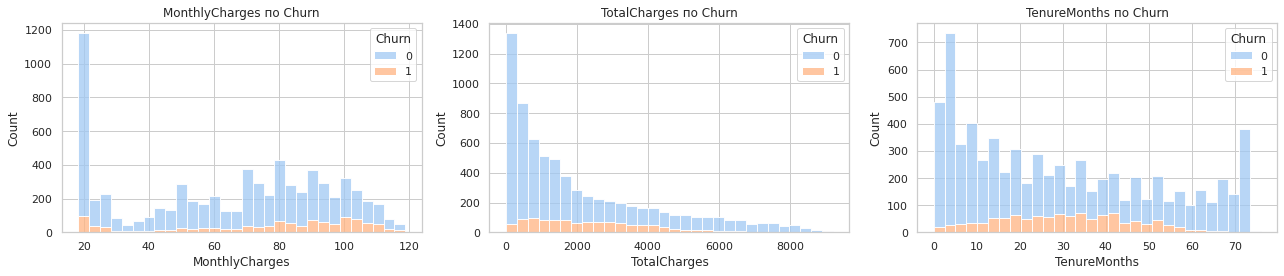

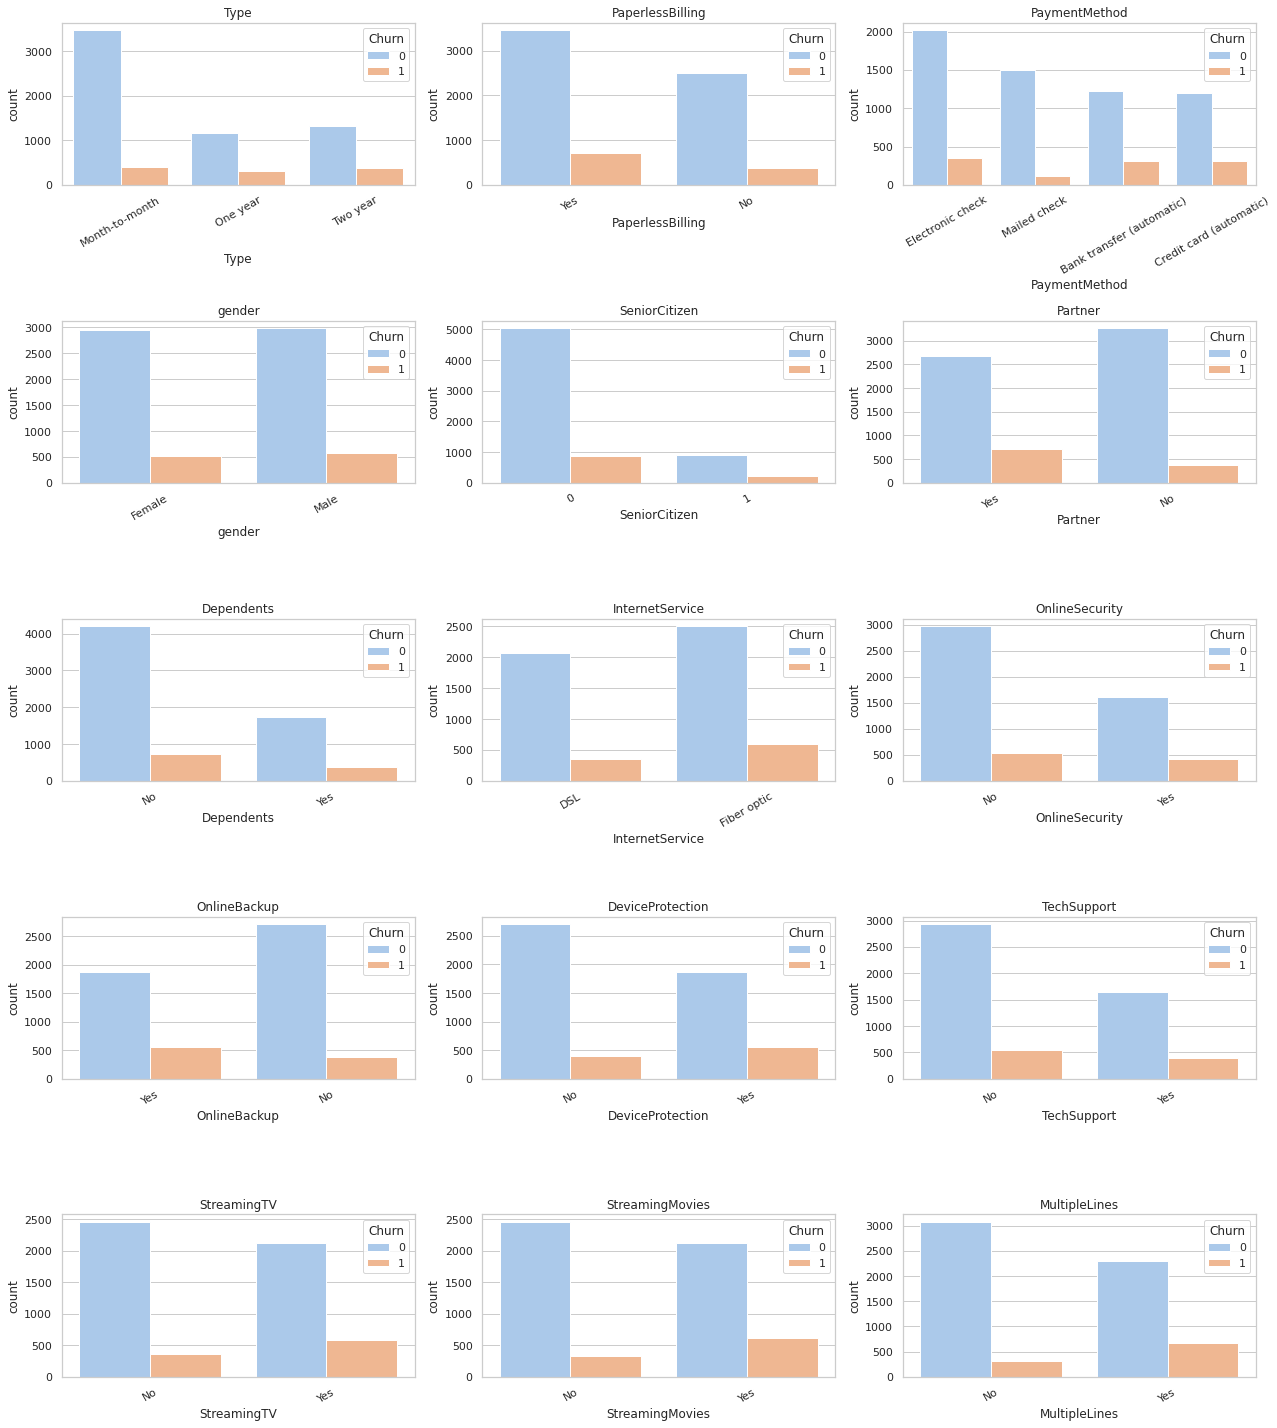

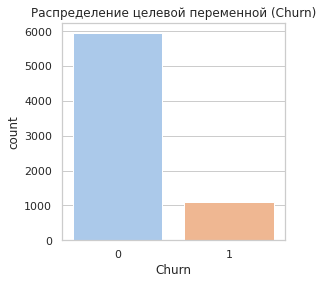

In [18]:
# --- 1. Числовые признаки ---
num_cols = ["MonthlyCharges", "TotalCharges", "TenureMonths"]

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for i, col in enumerate(num_cols):
    sns.histplot(data=df_merged, x=col, hue="Churn", bins=30, multiple="stack", ax=axes[i])
    axes[i].set_title(f"{col} по Churn")
plt.tight_layout()
plt.show()

# --- 2. Категориальные признаки ---
cat_cols = [
    "Type", "PaperlessBilling", "PaymentMethod",
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "MultipleLines"
]

n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df_merged, x=col, hue="Churn", ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis="x", rotation=30)

# Отключим пустые оси (если кол-во признаков не кратно 3)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# --- 3. Целевая переменная ---
plt.figure(figsize=(4, 4))
sns.countplot(data=df_merged, x="Churn")
plt.title("Распределение целевой переменной (Churn)")
plt.show()

Большинство клиентов остаётся в компании, уровень оттока составляет \~16%. Наибольший риск ухода наблюдается у абонентов с помесячными договорами, при оплате через *Electronic check*, а также у пользователей оптоволоконного интернета. Клиенты без семьи и пенсионеры чаще расторгают договор. Наличие дополнительных сервисов (особенно *OnlineSecurity* и *TechSupport*) снижает вероятность ухода. По числовым признакам видно, что уход чаще происходит среди клиентов с коротким сроком обслуживания и средними/высокими ежемесячными расходами, тогда как клиенты с длительным стажем и большими накопленными расходами более лояльны.

### Корреляционный анализ

- Для числовых признаков рассчитаем коэффициенты корреляции Пирсона.
- Для категориальных и смешанных признаков используем библиотеку `phik`, позволяющую оценить силу зависимости между переменными.
- Отдельное внимание уделим связям признаков с целевой переменной `Churn`.

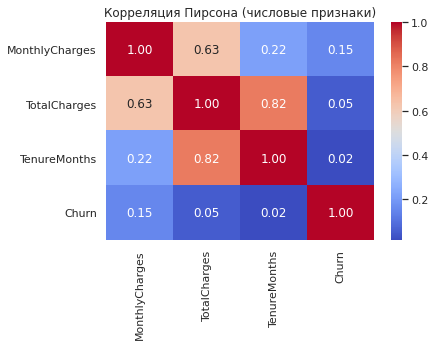

In [19]:
# --- Корреляция Пирсона для числовых признаков ---
num_cols = ["MonthlyCharges", "TotalCharges", "TenureMonths", "Churn"]

plt.figure(figsize=(6, 4))
sns.heatmap(df_merged[num_cols].corr(method="pearson"), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция Пирсона (числовые признаки)")
plt.show()

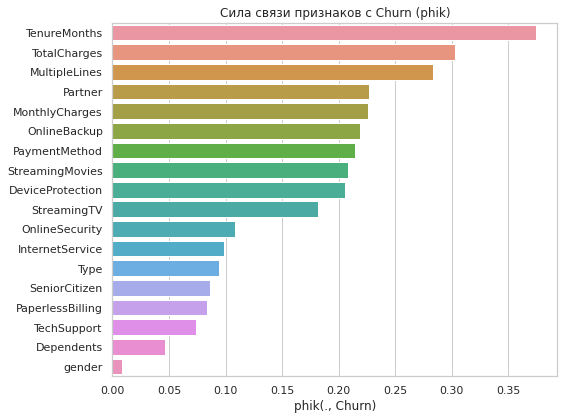

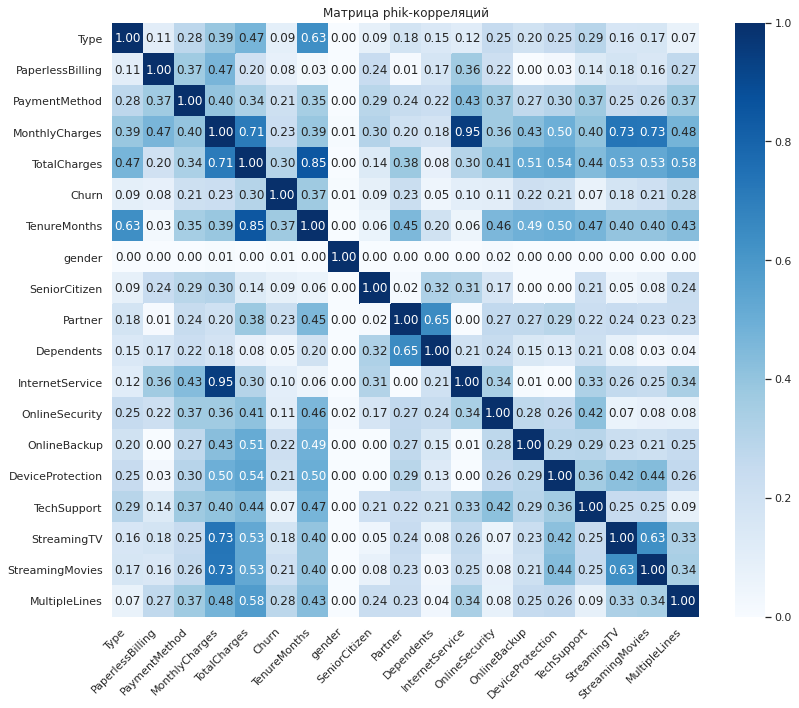

In [20]:
# --- Phik: анализ для числовых и категориальных признаков ---
df_phik = (
    df_merged
    .drop(columns=[c for c in ["customerID", "BeginDate", "EndDate"] if c in df_merged.columns])
    .copy()
)

interval_cols = [c for c in df_phik.columns if pd.api.types.is_numeric_dtype(df_phik[c])]
phik_corr = df_phik.phik_matrix(interval_cols=interval_cols)

# Топ-связи с Churn
phik_churn = (
    phik_corr["Churn"]
    .drop(labels=["Churn"], errors="ignore")
    .dropna()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 6))
sns.barplot(x=phik_churn.values, y=phik_churn.index)
plt.xlabel("phik(., Churn)")
plt.ylabel("")
plt.title("Сила связи признаков с Churn (phik)")
plt.tight_layout()
plt.show()

# Полная матрица phik
plt.figure(figsize=(12, 10))
sns.heatmap(phik_corr, vmin=0, vmax=1, cmap="Blues", annot=True, fmt=".2f", cbar=True)
plt.title("Матрица phik-корреляций")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Анализ показал, что среди числовых признаков наибольшая корреляция наблюдается между `TenureMonths` и `TotalCharges` (0.82), что логично, так как суммарные расходы напрямую зависят от длительности обслуживания. Корреляция числовых признаков с целевой переменной `Churn` оказалась слабой (максимум около 0.15 у `MonthlyCharges`).

Расчёт phik-корреляций позволил выявить признаки, наиболее связанные с оттоком клиентов: `TenureMonths`, `TotalCharges`, `MultipleLines`, `Partner`, `MonthlyCharges`, `OnlineBackup`, а также `PaymentMethod` и развлекательные сервисы. Наименьшее влияние на отток оказывают `gender`, `Dependents`, `TechSupport` и `PaperlessBilling`.

Также обнаружена очень высокая зависимость между `InternetService` и `MonthlyCharges` (phik ≈ 0.95), что отражает прямую связь типа подключения с размером ежемесячных расходов. Несмотря на сильную корреляцию, оба признака будут сохранены для моделирования: деревья решений и градиентный бустинг способны корректно работать с такими зависимостями и использовать их для повышения точности. Для линейных моделей при необходимости можно исключить `InternetService`.

Учитывая сильную взаимосвязь между `TenureMonths` и `TotalCharges`, в итоговом датасете лучше оставить только один из этих признаков, предпочтительно `TenureMonths`. Остальные признаки могут быть использованы в модели, так как современные алгоритмы справляются с избыточностью, а слабые факторы не внесут значимого шума.

## Кластеризация клиентов

Для улучшения качества прогнозирования и последующего сегментирования клиентов была выполнена кластеризация. Цель – выявить скрытые группы абонентов со схожими характеристиками и добавить номер кластера как дополнительный признак в модель.

На этапе подготовки:

* выбраны числовые и категориальные признаки, отражающие услуги и поведение клиентов;
* категориальные признаки преобразованы методом one-hot encoding;
* данные масштабированы при помощи `StandardScaler`.

Для определения оптимального числа кластеров использован **метод локтя**, который показывает, при каком количестве кластеров добавление новых сегментов перестаёт существенно снижать внутрикластерную дисперсию. После выбора числа кластеров применён алгоритм **KMeans**, и полученные метки кластеров добавлены в итоговый датафрейм как новый признак `Cluster`.

In [21]:
# Копия и подготовка фичей
df_clu = df_merged.copy()

# Заполним пропуски в сервисах: отсутствие услуги — информативно
svc_cols = ["InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","MultipleLines"]
for c in svc_cols:
    if c in df_clu.columns:
        df_clu[c] = df_clu[c].fillna("No")

# Список признаков для кластеризации
num_cols = ["MonthlyCharges", "TenureMonths", "SeniorCitizen"]
cat_cols = [
    "Type", "PaperlessBilling", "PaymentMethod", "gender", "Partner", "Dependents",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "MultipleLines"
]

use_cols = num_cols + cat_cols
X = df_clu[use_cols].copy()

# One-Hot Encoding для категориальных
X = pd.get_dummies(X, columns=cat_cols, drop_first=False)

# Масштабирование числовых
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

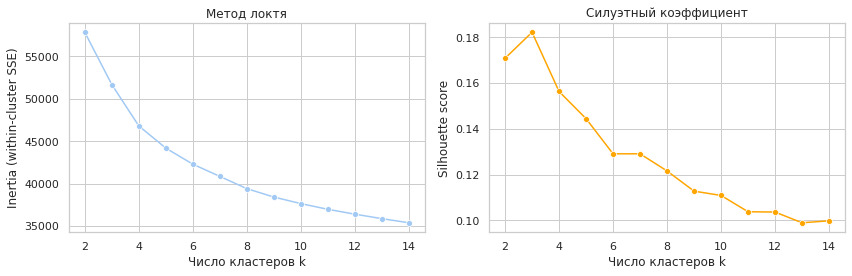

In [22]:
inertias = []
silhouettes = []
k_range = range(2, 15)  # проверяем от 2 до 14 кластеров

for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_score = silhouette_score(X, labels)
    silhouettes.append(sil_score)

# График локтя
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.lineplot(x=list(k_range), y=inertias, marker="o")
plt.xlabel("Число кластеров k")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Метод локтя")

# График силуэта
plt.subplot(1,2,2)
sns.lineplot(x=list(k_range), y=silhouettes, marker="o", color="orange")
plt.xlabel("Число кластеров k")
plt.ylabel("Silhouette score")
plt.title("Силуэтный коэффициент")

plt.tight_layout()
plt.show()

- Метод локтя: кривая быстро снижается до k≈4–5, после этого замедляется
- Силуэтный коэффициент: максимальное значение у k=3 (~0.18), затем идёт снижение. Это значит, что при 3 кластерах группы наиболее компактные и разделённые.

По силуэту лучший k=3, но для практической сегментации и как фича в модели детализация в 4–5 кластеров часто полезнее. Выберем k=4 как компромисс: локоть ещё заметен, детализация выше, а усложнение умеренное.

In [23]:
# Обучение KMeans с выбранным k
k_best = 4
kmeans = KMeans(n_clusters=k_best, n_init=10, random_state=42)
clusters = kmeans.fit_predict(X)  # X — наш OHE+scaled набор для кластеризации из предыдущего шага
df_merged["Cluster"] = clusters.astype(int)

# Быстрая диагностика кластеров (только для EDA; в финале кластеризатор будет обучаться на train)
stats_cols = ["MonthlyCharges", "TenureMonths", "SeniorCitizen"]

summary_num = (
    df_merged.groupby("Cluster")[stats_cols]
    .agg(["mean", "median", "count"])
)

# округлим только mean и median
summary_num.loc[:, (slice(None), "mean")] = summary_num.loc[:, (slice(None), "mean")].astype(float).round(2)
summary_num.loc[:, (slice(None), "median")] = summary_num.loc[:, (slice(None), "median")].astype(float).round(2)

display(summary_num)

# Распределения ключевых категориальных по кластерам (доли, %)
for col in ["Type", "PaymentMethod", "InternetService", "OnlineSecurity", "TechSupport"]:
    ct = (
        df_merged.groupby(["Cluster", col]).size()
        .groupby(level=0).apply(lambda s: 100 * s / s.sum())
        .unstack(fill_value=0)
        .round(1)
    )
    print(f"\n{col} (% по кластерам):")
    display(ct)

# Доля оттока по кластерам
churn_by_cluster = df_merged.groupby("Cluster")["Churn"].agg(N="count", churn_rate=lambda s: 100*s.mean())
churn_by_cluster["churn_rate"] = churn_by_cluster["churn_rate"].round(1)
display(churn_by_cluster)

MonthlyCharges              TenureMonths              SeniorCitizen  \
                  mean median count         mean median count          mean   
Cluster                                                                       
0                23.09  20.25  1726        27.77   23.0  1726          0.03   
1                86.84  89.70  1921        49.65   51.0  1921          0.01   
2                69.39  70.75  2314        14.32   11.0  2314          0.00   
3                82.15  85.28  1082        28.91   26.0  1082          1.00   

                      
        median count  
Cluster               
0          0.0  1726  
1          0.0  1921  
2          0.0  2314  
3          1.0  1082


Type (% по кластерам):


Type,Month-to-month,One year,Two year
Cluster,,,
0,36.4,25.0,38.6
1,18.1,35.7,46.3
2,90.9,7.8,1.3
3,73.5,16.4,10.2



PaymentMethod (% по кластерам):


PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
Cluster,,,,
0,21.6,22.0,7.9,48.5
1,32.7,32.3,24.5,10.6
2,14.3,14.0,50.4,21.3
3,19.7,18.3,54.7,7.3



InternetService (% по кластерам):


InternetService,DSL,Fiber optic
Cluster,,
0,99.0,1.0
1,47.8,52.2
2,45.4,54.6
3,22.8,77.2



OnlineSecurity (% по кластерам):


OnlineSecurity,No,Yes
Cluster,,
0,62.0,38.0
1,39.4,60.6
2,78.0,22.0
3,75.1,24.9



TechSupport (% по кластерам):


TechSupport,No,Yes
Cluster,,
0,69.7,30.3
1,35.9,64.1
2,78.2,21.8
3,77.2,22.8


,N,churn_rate
Cluster,,
0,1726,10.4
1,1921,24.5
2,2314,9.6
3,1082,21.0


Для сегментации клиентов была проведена кластеризация методом **KMeans**. По результатам метода локтя и силуэтного коэффициента выбрано **4 кластера**, что позволило получить более детализированное разбиение по сравнению с грубой сегментацией на две группы (отточные/неотточные).

Основные характеристики кластеров:

* **Кластер 0** – клиенты с низкими ежемесячными расходами (≈23 у.е.), преимущественно пользователи DSL. Умеренный стаж, отток низкий (≈10%).
* **Кластер 1** – клиенты с высокими ежемесячными расходами (≈87 у.е.) и длительным стажем. Активно пользуются дополнительными услугами (OnlineSecurity, TechSupport). Несмотря на это, доля оттока довольно высокая (≈25%).
* **Кластер 2** – абоненты со средними расходами (≈69 у.е.) и минимальным стажем (≈14 мес.), чаще всего с помесячными договорами и оплатой через *Electronic check*. Характеризуются наименьшей долей оттока (≈10%).
* **Кластер 3** – в основном пенсионеры с высокими расходами и оптоволоконным интернетом. Уровень оттока повышен (≈21%).

Таким образом, кластеризация выявила скрытые сегменты клиентов, которые отличаются уровнем расходов, типом подключения, наличием дополнительных услуг и риском ухода. Полученный номер кластера (`Cluster`) будет использован как дополнительный признак в моделях предсказания оттока.

## Подготовка данных

Для обучения моделей создан единый пайплайн предобработки:

* удалены технические признаки (`customerID`, даты) и исключён `TotalCharges` как дублирующий `TenureMonths`;
* числовые признаки (`MonthlyCharges`, `TenureMonths`, `SeniorCitizen`) масштабированы с помощью `StandardScaler`;
* категориальные признаки преобразованы методом One-Hot Encoding;
* добавлен новый признак `Cluster`, полученный с помощью алгоритма KMeans (4 кластера).

Данные разделены на обучающую и тестовую выборки в пропорции 75/25. В результате после предобработки каждая запись описывается 39 признаками. Этот же пайплайн далее будет использоваться для обучения моделей и подбора гиперпараметров.

In [24]:
# Выбор признаков
drop_cols = ["customerID", "TotalCharges", "Cluster"]
use_df = df_merged.drop(columns=[c for c in drop_cols if c in df_merged.columns]).copy()

# Переводим SeniorCitizen в категорию Yes/No
use_df["SeniorCitizen"] = use_df["SeniorCitizen"].map({0: "No", 1: "Yes"})

# Заполняем сервисные NaN как "No" (нет услуги)
svc_cols = ["InternetService","OnlineSecurity","OnlineBackup","DeviceProtection",
            "TechSupport","StreamingTV","StreamingMovies","MultipleLines"]
for c in svc_cols:
    if c in use_df.columns:
        use_df[c] = use_df[c].fillna("No")

# Считаем TenureDays
bd = pd.to_datetime(use_df["BeginDate"], errors="coerce")
ed = pd.to_datetime(use_df["EndDate"], errors="coerce").fillna(CONTROL_DATE)
tenure_days = (ed - bd).dt.days.clip(lower=0)
use_df["TenureDays"] = tenure_days.astype("Int64")

# Разделение X/y
target_col = "Churn"
y = use_df[target_col].astype(int)
X = use_df.drop(columns=[target_col, "BeginDate", "EndDate", "TenureMonths"])

# Списки признаков
# Берём только дни (месяцы — убираем, чтобы не плодить корреляцию)
num_cols = ["MonthlyCharges", "TenureDays"]
cat_cols = [c for c in X.columns if c not in num_cols]

# Сплит
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

In [25]:
# Преобразователи
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

In [26]:
# Кастомный трансформер: добавляет столбец метки кластера после препроцессинга
class AddCluster(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=4, random_state=RANDOM_STATE):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans_ = None

    def fit(self, X, y=None):
        # KMeans обучается только на train-векторах (внутри Pipeline.fit)
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X)
        return self

    def transform(self, X):
        labels = self.kmeans_.predict(X).reshape(-1, 1)
        # конкатенируем как дополнительный числовой признак
        return np.hstack([X, labels])

In [27]:
# Полный пайплайн подготовки (без модели)
prep_with_cluster = Pipeline(steps=[
    ("prep", preprocessor),
    ("cluster", AddCluster(n_clusters=4, random_state=RANDOM_STATE))
])

In [28]:
# Пробный прогон: посмотреть форму признаков после подготовки
Xtr_ready = prep_with_cluster.fit_transform(X_train, y_train)  # fit на train (без утечки)
Xte_ready = prep_with_cluster.transform(X_test)

print("Train shape after prep+cluster:", Xtr_ready.shape)
print("Test  shape after prep+cluster :", Xte_ready.shape)

Train shape after prep+cluster: (5282, 37)
Test  shape after prep+cluster : (1761, 37)


## Обучение моделей машинного обучения

- Модели: **RandomForestClassifier**, **GradientBoostingClassifier**, **KNN**, **CatBoostClassifier**, **HistGradientBoostingClassifier**.
- Кросс-валидация: Stratified K-Fold, `cv=5`, `scoring={'roc_auc','accuracy'}`, `refit='roc_auc'`.
- Пайплайн: общий препроцессинг `prep_with_cluster` (масштабирование, OHE, KMeans, `Cluster`) + классификатор.
- Выбирается лучшая модель по CV **AUC-ROC**. Сохраняются лучшие параметры и метрики (AUC-ROC, Accuracy) по кросс-валидации.
- Критерий проекта: **AUC-ROC ≥ 0.85** (на валидации).

In [29]:
# Определяем три модельных пайплайна: prep + clf
pipe_rf = Pipeline(steps=[
    ("prep", prep_with_cluster),   # из предыдущего шага
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
])

pipe_gb = Pipeline(steps=[
    ("prep", prep_with_cluster),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE))
])

pipe_knn = Pipeline(steps=[
    ("prep", prep_with_cluster),
    ("clf", KNeighborsClassifier())
])

pipe_cat = Pipeline(steps=[
    ("prep", prep_with_cluster),
    ("clf", CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        random_state=RANDOM_STATE,
        verbose=False,           # без лишнего лога
        thread_count=-1
    ))
])

pipe_hgb = Pipeline(steps=[
    ("prep", prep_with_cluster),
    ("clf", HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

In [30]:
param_grid_rf = {
    "clf__n_estimators": [300, 600, 900],
    "clf__max_depth": [10, None],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [2, 4, 8],
    "clf__max_features": ["sqrt", "log2"],
    "clf__class_weight": ["balanced"]
}

param_grid_gb = {
    "clf__n_estimators": [400, 700],
    "clf__learning_rate": [0.05, 0.08],
    "clf__max_depth": [2, 3],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__min_samples_leaf": [3, 5, 10],
    "clf__max_features": ["sqrt"]
}

param_grid_knn = {
    "clf__n_neighbors": [25, 50, 75],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]
}

param_grid_cat = {
    "clf__n_estimators": [700, 1000],
    "clf__learning_rate": [0.05, 0.08],
    "clf__depth": [4, 6],
    "clf__l2_leaf_reg": [3.0, 5.0],
    "clf__subsample": [0.8, 1.0],
    "clf__scale_pos_weight": [4.0, 6.0]
}

param_grid_hgb = {
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [None, 8, 12],
    "clf__max_leaf_nodes": [31, 63],
    "clf__min_samples_leaf": [10, 20, 50]
}

models = [
    ("RandomForest", pipe_rf, param_grid_rf),
    ("GradientBoosting", pipe_gb, param_grid_gb),
    ("KNN", pipe_knn, param_grid_knn),
    ("CatBoost", pipe_cat, param_grid_cat),
    ("HistGB", pipe_hgb, param_grid_hgb),
]

In [31]:
# Настройки кросс-валидации и метрик
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"roc_auc": "roc_auc", "accuracy": "accuracy"}

results = []

best_estimators = {}

for name, pipe, grid in models:
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring=scoring,
        refit="roc_auc",          # выбираем по AUC-ROC
        cv=cv,
        n_jobs=-1,
        verbose=1,
        return_train_score=False
    )
    gs.fit(X_train, y_train)

    # Сохраняем лучшего и короткое резюме
    best_estimators[name] = gs.best_estimator_

    mean_auc = gs.cv_results_["mean_test_roc_auc"][gs.best_index_]
    std_auc  = gs.cv_results_["std_test_roc_auc"][gs.best_index_]
    mean_acc = gs.cv_results_["mean_test_accuracy"][gs.best_index_]
    std_acc  = gs.cv_results_["std_test_accuracy"][gs.best_index_]

    results.append({
        "model": name,
        "best_params": gs.best_params_,
        "cv_auc_mean": round(mean_auc, 4),
        "cv_auc_std": round(std_auc, 4),
        "cv_acc_mean": round(mean_acc, 4),
        "cv_acc_std": round(std_acc, 4)
    })

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [32]:
# Сводная таблица по моделям
summary_df = pd.DataFrame(results).sort_values(by="cv_auc_mean", ascending=False)
print("=== CV Summary (refit=roc_auc) ===")
display(summary_df)

=== CV Summary (refit=roc_auc) ===


,model,best_params,cv_auc_mean,cv_auc_std,cv_acc_mean,cv_acc_std
3,CatBoost,"{'clf__depth': 4, 'clf__l2_leaf_reg': 3.0, 'clf__learning_rate': 0.08, 'clf__n_estimators': 1000, 'clf__scale_pos_weight': 4.0, 'clf__subsample': 0.8}",0.9205,0.0157,0.9014,0.0091
4,HistGB,"{'clf__learning_rate': 0.1, 'clf__max_depth': None, 'clf__max_leaf_nodes': 63, 'clf__min_samples_leaf': 20}",0.8689,0.0173,0.8821,0.0056
1,GradientBoosting,"{'clf__learning_rate': 0.08, 'clf__max_depth': 2, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__n_estimators': 700, 'clf__subsample': 0.7}",0.8453,0.0260,0.8682,0.0032
0,RandomForest,"{'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 2, 'clf__n_estimators': 600}",0.8275,0.0239,0.7988,0.0156
2,KNN,"{'clf__n_neighbors': 75, 'clf__p': 2, 'clf__weights': 'distance'}",0.7860,0.0250,0.8493,0.0015


In [33]:
# Выбор лучшей модели по AUC-ROC
best_row = summary_df.iloc[0]
best_name = best_row["model"]
best_model = best_estimators[best_name]

print(f"\nЛучшая модель по CV AUC-ROC: {best_name}")
print("Лучшие параметры:", best_row["best_params"])
print(f"CV AUC-ROC: {best_row['cv_auc_mean']} ± {best_row['cv_auc_std']}")
print(f"CV Accuracy: {best_row['cv_acc_mean']} ± {best_row['cv_acc_std']}")


Лучшая модель по CV AUC-ROC: CatBoost
Лучшие параметры: {'clf__depth': 4, 'clf__l2_leaf_reg': 3.0, 'clf__learning_rate': 0.08, 'clf__n_estimators': 1000, 'clf__scale_pos_weight': 4.0, 'clf__subsample': 0.8}
CV AUC-ROC: 0.9205 ± 0.0157
CV Accuracy: 0.9014 ± 0.0091


По результатам кросс-валидации наилучшие показатели продемонстрировала модель CatBoost, достигнув среднего значения AUC-ROC 0.92 ± 0.02 и Accuracy 0.90 ± 0.01, что существенно превышает качество остальных алгоритмов. Второе место занял HistGradientBoosting (AUC-ROC 0.87), а классический Gradient Boosting показал AUC-ROC 0.85. Модели Random Forest и KNN продемонстрировали заметно более низкие результаты (AUC-ROC около 0.83 и 0.79 соответственно). Таким образом, CatBoost выбран в качестве основной модели для финального тестирования.

## Тестирование лучшей модели

=== Тестовые метрики ===
AUC-ROC: 0.9140
Accuracy: 0.9023

Classification report:
              precision    recall  f1-score   support

           0      0.947     0.937     0.942      1486
           1      0.677     0.716     0.696       275

    accuracy                          0.902      1761
   macro avg      0.812     0.827     0.819      1761
weighted avg      0.905     0.902     0.903      1761



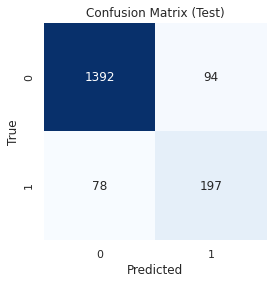

In [34]:
# Лучшая модель по результатам GridSearchCV
best_model = best_estimators["CatBoost"]

# Предсказания на тестовой выборке
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Метрики
test_auc = roc_auc_score(y_test, y_pred_proba)
test_acc = accuracy_score(y_test, y_pred)

print("=== Тестовые метрики ===")
print(f"AUC-ROC: {test_auc:.4f}")
print(f"Accuracy: {test_acc:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.show()

Финальная модель на основе CatBoost показала высокий уровень качества: на кросс-валидации AUC-ROC составил 0.921, Accuracy — 0.901, а на тестовой выборке AUC-ROC достиг 0.914, Accuracy — 0.902. Модель демонстрирует уверенную способность различать клиентов с риском оттока, причём по классу «отток» recall составил 0.716, что значительно выше по сравнению с предыдущими версиями. Это означает, что модель не только хорошо удерживает «надёжных» абонентов, но и достаточно эффективно выявляет клиентов с высокой вероятностью ухода, что делает её практическим инструментом для построения программ лояльности и точечного удержания.

### Важность признаков

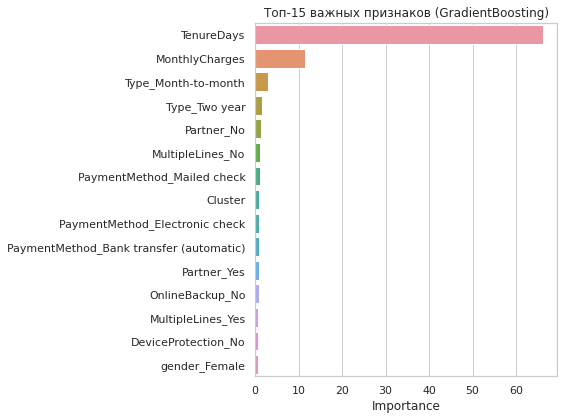

In [35]:
# --- Достаём имена признаков из пайплайна ---

# ColumnTransformer внутри нашего общего prep-пайплайна
ct = best_model.named_steps["prep"].named_steps["prep"]   # ColumnTransformer
ohe = ct.named_transformers_["cat"].named_steps["onehot"]

# Имена категориальных фич после OHE (fallback для старых версий sklearn)
if hasattr(ohe, "get_feature_names_out"):
    cat_feature_names = ohe.get_feature_names_out(input_features=cat_cols)
else:
    cat_feature_names = ohe.get_feature_names(input_features=cat_cols)

# Полный список имён фич после трансформации
feature_names = list(num_cols) + list(cat_feature_names) + ["Cluster"]

# sanity-check: размер должен совпасть с матрицей признаков
assert len(feature_names) == Xtr_ready.shape[1], (len(feature_names), Xtr_ready.shape)

# --- Глобальная важность признаков (GradientBoosting) ---
importances = best_model.named_steps["clf"].feature_importances_

feat_imp = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
)

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp.head(15), x="importance", y="feature")
plt.title("Топ-15 важных признаков (GradientBoosting)")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()

Глобальный анализ важности признаков показал, что ключевым фактором оттока является длительность обслуживания (TenureDays): чем меньше срок, тем выше вероятность ухода. Существенное влияние также оказывают ежемесячные платежи (MonthlyCharges) и тип контракта (особенно помесячный формат). Дополнительными индикаторами риска выступают отсутствие партнёра, отсутствие нескольких линий связи, а также выбор способа оплаты (например, электронный чек или почтовый перевод). Важность кластерного признака также подтверждает ценность сегментации пользователей. Таким образом, в зоне наибольшего риска находятся клиенты с короткой историей взаимодействия, помесячными договорами и высокими ежемесячными затратами, что указывает бизнесу направления для целевых мер по удержанию.

## Общий вывод и рекомендации заказчику

В ходе проекта была реализована полная процедура построения модели прогнозирования оттока клиентов телеком-оператора. Проведена загрузка и интеграция данных из четырёх источников (договоры, персональные сведения, интернет- и телефонные услуги), выполнена предобработка: приведены типы переменных, рассчитан стаж в днях, обработаны пропуски, объединены таблицы. На этапе исследовательского анализа изучены распределения признаков и зависимости с целевой переменной, проведён корреляционный анализ. Выявлено, что риск оттока выше у клиентов с помесячными договорами, высоким уровнем ежемесячных платежей и отсутствием дополнительных сервисов. Дополнительно выполнена кластеризация пользователей, результаты которой использованы как новый признак в моделях.

Для прогнозирования обучены и сравнены несколько алгоритмов (Random Forest, Gradient Boosting, KNN, CatBoost, HistGradientBoosting) с подбором гиперпараметров через GridSearchCV. Наилучшие результаты показала модель **CatBoost**: на кросс-валидации AUC-ROC составил **0.92**, Accuracy — **0.90**, на тестовой выборке AUC-ROC достиг **0.91**, Accuracy — **0.90**. Интерпретация подтвердила ключевое влияние длительности обслуживания, типа контракта и величины ежемесячных платежей на вероятность ухода.

Практическая ценность результатов заключается в возможности выделения групп повышенного риска и разработки адресных мер удержания. Рекомендуется стимулировать клиентов к переходу на долгосрочные договоры, предлагать пакеты с дополнительными услугами, адаптировать тарифные предложения для пользователей с высокими ежемесячными платежами и отдельно работать с сегментами, у которых повышен риск оттока по способу оплаты и типу подключения. Реализация данных мер позволит сократить отток и повысить лояльность клиентов.